In [ ]:
#| default_exp importance_sampling

# Importance Sampling for Log Concave State Space Models

After having observed $Y$ one is usually interested in properties of the conditional distribution of states $X$ given $Y$. Typically this means terms of the form

$$
\mathbf E (f(X) | Y) = \mathbf E (f(X_0, \dots, X_n) | Y_0, \dots, Y_n) = \int f(x_0, \dots, x_n) p(x_0, \dots, x_n | y_0, \dots, y_n) \mathrm d x_0 \dots \mathrm d x_n.
$$

As the density $p(x|y)$ is known only up to a constant, we resort to importance sampling with a GLSSM, represented by its $g$, which can be obtained e.g. by [mode estimation](40_mode_estimation.ipynb) or [(modified) efficient importance sampling](50_modified_efficient_importance_sampling.ipynb). We'll assume throughout that $p(x) = g(x)$, i.e. that the prior for the states did not change in the approximation.

In this setting we can transform the expectation w.r.t the condtiional density $p(x|y)$ to one w.r.t the density $g(x|z)$ where $z$ are some synthetic observations. 

$$
\begin{align*}
\int f(x) p(x|y) \mathrm d x &= \int f(x) \frac{p(x|y)}{g(x|z)} g(x|z) \mathrm d x\\
&= \int f(x) \frac{p(y|x)}{g(z|x)} \frac{g(z)}{p(y)} g(x|z) \mathrm d x.
\end{align*}
$$

Let $w(x) = \frac{p(y|x)}{g(z|x)} = \frac{p(y|s)}{g(z|s)}$ be the (unnormalized) importance sampling weights which only depend on $s_t = B_t x_t$, $t = 0, \dots, n$.

In [ ]:
#| export
import tensorflow_probability.substrates.jax.distributions as tfd
import jax.numpy as jnp

from isssm.lcssm import v_time
MVN = tfd.MultivariateNormalFullCovariance

def log_weights_t(t, s, y, xi_fun, dist, z, Omega):
    m = s.shape
    params = xi_fun(t, s)
    p_ys = dist(params).log_prob(y).sum()
    g_zs = MVN(s, Omega).log_prob(z).sum()
    
    return p_ys - g_zs
    
def log_weights(s,y, xi_fun, dist, z, Omega):
    np1, m = s.shape
    n = np1 - 1
    params = v_time(xi_fun)(jnp.arange(n + 1), s)

    p_ys = dist(params).log_prob(y).sum()
    g_zs = MVN(s, Omega).log_prob(z).sum()
    
    return p_ys - g_zs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


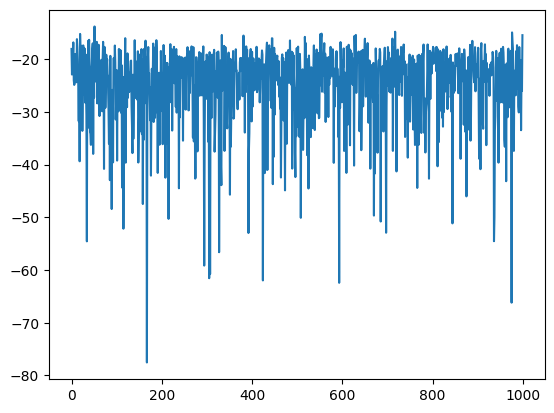

In [ ]:
from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.glssm import FFBS
from isssm.kalman import kalman
import jax.random as jrn
from isssm.mode_estimation import mode_estimation
import jax.numpy as jnp
from jax import vmap
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
m, p, n = 3, 2, 10
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, xi_fun, dist = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(_, ), (y,) = simulate_lcssm(x0, A, Sigma, B, xi_fun, dist, N, subkey)
s_init = jnp.log(y + 1.)
x_smooth, z, Omega = mode_estimation(y, x0, A, Sigma, B, xi_fun, dist, s_init, 10)

N = 1000
samples = FFBS(z, x0, Sigma, Omega, A, B, 1000, jrn.PRNGKey(423423))

vB = partial(vmap(jnp.matmul), B)

s = vmap(vB)(samples)

vlw = vmap(log_weights, (0, None, None, None, None, None))
lw = vlw(s, y, xi_fun, dist, z, Omega)
plt.plot(lw)
plt.show()

Weights should be calculated on the log scale, but we need them on the usual scale to use for Monte-Carlo integration. As weights are only known up to a constant, we make exponentiation numerically stable by substracting (on the log-scale) the largest weight, ensuring that $\log w^i \leq 0$ for all weights and so $\sum_{i = 1}^N w^i \leq N$. 

In [ ]:
#| export
def normalize_weights(log_weights):
    max_weight = jnp.max(log_weights)

    log_weights_corrected = log_weights - max_weight

    weights = jnp.exp(log_weights_corrected)

    return weights / weights.sum()

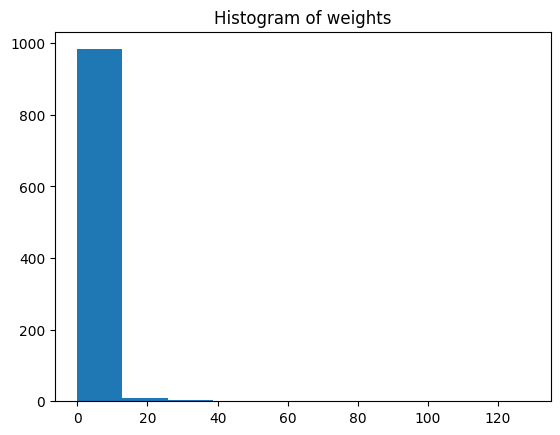

In [ ]:
weights = normalize_weights(lw)

plt.hist(weights * N)
plt.title("Histogram of weights")
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()